In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
# result paths generated in prev. Notebooks
dir_FGH_feat = "./features_FGH"
dir_FG_feat = "./features_FG_only"
dir_FGH_field_final = "./FGH1210"
dir_FGH_field_bfH = "./FGH1210_beforeH"
dir_FG_field = "./FG_only1210"

dir_raw_FGH = os.path.join(dir_FGH_feat, "rwa_feat")
dir_raw_FG = os.path.join(dir_FG_feat,  "rwa_feat")
dir_denoise_FGH = os.path.join(dir_FGH_feat, "denoised_feat")
dir_denoise_FG = os.path.join(dir_FG_feat,  "denoised_feat")

In [3]:
def load_feat(path: str) -> np.ndarray:
    """
    read feature，compatible with (H, W, C) and (1, H, W, C).
    """
    x = np.load(path)
    if x.ndim == 4 and x.shape[0] == 1:
        x = x[0]
    return x.astype(np.float32)


def mse(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.mean((a - b) ** 2))


def flatten_state_dict(sd: "dict[str, torch.Tensor]") -> torch.Tensor:
    """
    flatten all Tensor parameters and return in a 1-D vector.
    """
    vecs = []
    for k, v in sd.items():
        if isinstance(v, torch.Tensor):
            vecs.append(v.reshape(-1).float())
    return torch.cat(vecs, dim=0)


def relative_l2(a: torch.Tensor, b: torch.Tensor) -> float:
    """
    Compute the relative change of L2 norm ||b - a||_2 / ||a||_2
    """
    a = a.float()
    b = b.float()
    num = torch.norm(b - a)
    denom = torch.norm(a)
    if denom.item() == 0:
        return 0.0
    return (num / denom).item()



# A1 per-image MSE: FG-only vs FGH
def run_A1():
    FGH_files = sorted(os.listdir(dir_denoise_FGH))
    FG_files  = sorted(os.listdir(dir_denoise_FG))
    common_files = sorted(list(set(FGH_files) & set(FG_files)))
    print(f"[A1] Common images: {len(common_files)}")

    MSE_FGH = []
    MSE_FG  = []

    for fname in common_files:
        raw_FGH = load_feat(os.path.join(dir_raw_FGH, fname))
        raw_FG  = load_feat(os.path.join(dir_raw_FG,  fname))
        den_FGH = load_feat(os.path.join(dir_denoise_FGH, fname))
        den_FG  = load_feat(os.path.join(dir_denoise_FG,  fname))

        MSE_FGH.append(mse(raw_FGH, den_FGH))
        MSE_FG.append(mse(raw_FG,  den_FG))

    MSE_FGH = np.array(MSE_FGH)
    MSE_FG  = np.array(MSE_FG)

    print(f"[A1] FGH mean MSE: {MSE_FGH.mean():.6f}")
    print(f"[A1] FG-only mean MSE: {MSE_FG.mean():.6f}")

    # scatter plot：FG-only vs FGH
    plt.figure(figsize=(6, 6))
    plt.scatter(MSE_FG, MSE_FGH, s=8, alpha=0.5)
    lo = min(MSE_FG.min(), MSE_FGH.min())
    hi = max(MSE_FG.max(), MSE_FGH.max())
    plt.plot([lo, hi], [lo, hi], "r--", label="y = x")
    plt.xlabel("MSE (FG-only)")
    plt.ylabel("MSE (FGH)")
    plt.title("Reconstruction Error: FG-only vs FGH")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # hist plot：MSE(FG-only) - MSE(FGH)
    diff = MSE_FG - MSE_FGH
    plt.figure(figsize=(6, 4))
    plt.hist(diff, bins=40, alpha=0.7)
    plt.axvline(0, color="red", linestyle="--")
    plt.xlabel("MSE(FG-only) - MSE(FGH)")
    plt.ylabel("Count")
    plt.title("Error Difference Distribution")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

    return MSE_FG, MSE_FGH, common_files



# A2: examine how F and G change after using H
# ΔG is always 0, which shows the idea of paper is correctly implemented.

def run_A2():
    files_final   = sorted(os.listdir(dir_FGH_field_final))
    files_beforeH = sorted(os.listdir(dir_FGH_field_bfH))
    common_ckpts  = sorted(list(set(files_final) & set(files_beforeH)))
    print(f"[A2] Common checkpoints: {len(common_ckpts)}")

    delta_F_list = []
    delta_G_list = []

    for fname in common_ckpts:
        path_before = os.path.join(dir_FGH_field_bfH, fname)
        path_final  = os.path.join(dir_FGH_field_final,   fname)

        ckpt_before = torch.load(path_before, map_location="cpu")
        ckpt_final  = torch.load(path_final,  map_location="cpu")

        F_before_sd = ckpt_before["F_neural_field"]
        F_final_sd  = ckpt_final["F_neural_field"]

        F_before_vec = flatten_state_dict(F_before_sd)
        F_final_vec  = flatten_state_dict(F_final_sd)

        delta_F = relative_l2(F_before_vec, F_final_vec)
        delta_F_list.append(delta_F)

        G_before = ckpt_before["G_shared_artifacts"]    # (1, C, H, W)
        G_final  = ckpt_final["G_shared_artifacts"]

        G_before_vec = G_before.reshape(-1).float()
        G_final_vec  = G_final.reshape(-1).float()

        delta_G = relative_l2(G_before_vec, G_final_vec)
        delta_G_list.append(delta_G)

    delta_F = np.array(delta_F_list)
    delta_G = np.array(delta_G_list)

    print(f"[A2] ΔF mean:   {delta_F.mean():.6f}, median: {np.median(delta_F):.6f}")
    print(f"[A2] ΔF min/max: {delta_F.min():.6f} / {delta_F.max():.6f}")
    print(f"[A2] G is frozen: {all(np.isclose(delta_G, 0))}")
    

    plt.figure(figsize=(10, 4))
    plt.hist(delta_F, bins=40, alpha=0.7)
    plt.title("ΔF = ||F_final - F_beforeH|| / ||F_beforeH||")
    plt.xlabel("ΔF")
    plt.ylabel("Count")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


    
    plt.figure(figsize=(4, 5))
    plt.boxplot([delta_F, delta_G], labels=["ΔF", "ΔG"])
    plt.ylabel("Relative L2 change")
    plt.title("Change after enabling H")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

    return delta_F, delta_G, common_ckpts



[A1] Common images: 954
[A1] FGH mean MSE: 0.987972
[A1] FG-only mean MSE: 0.792437


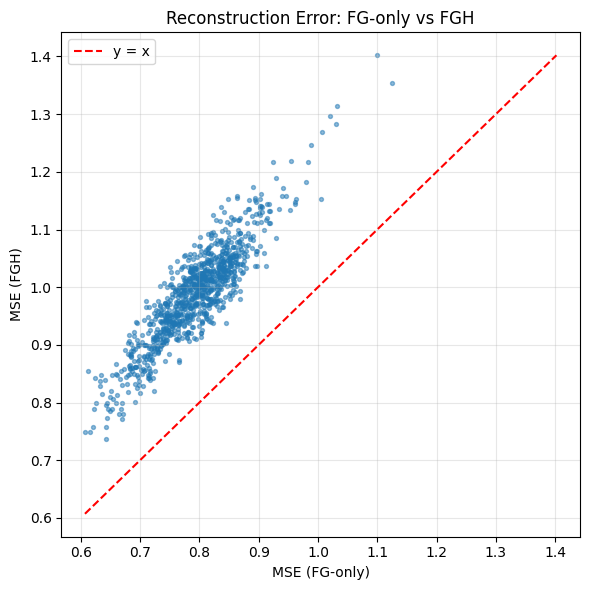

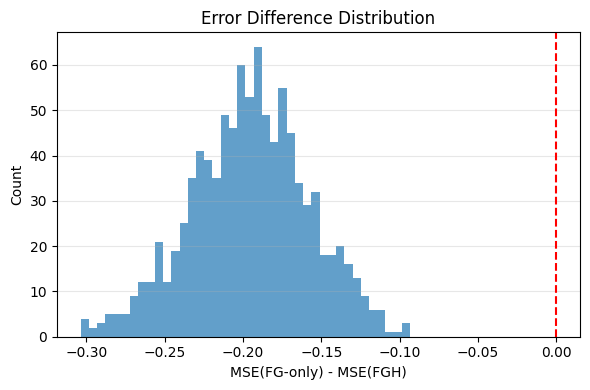

[A2] Common checkpoints: 954
[A2] ΔF mean:   0.516086, median: 0.516168
[A2] ΔF min/max: 0.465761 / 0.566746
[A2] G is frozen: True


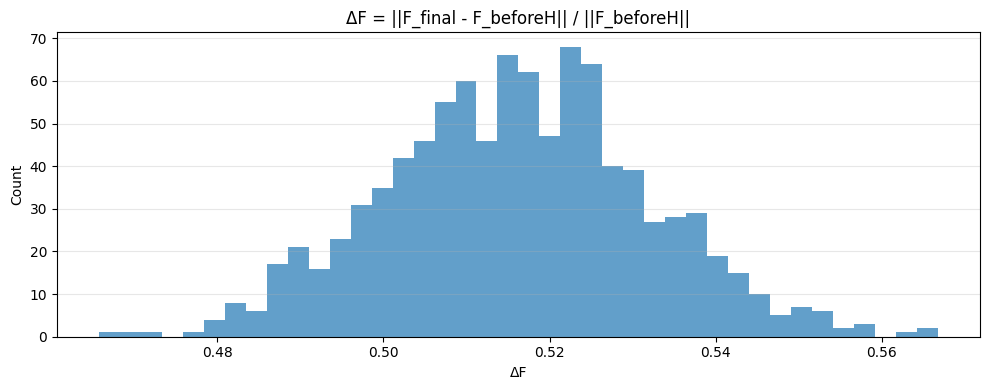

/tmp/ipykernel_46639/2822319725.py:152: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([delta_F, delta_G], labels=["ΔF", "ΔG"])


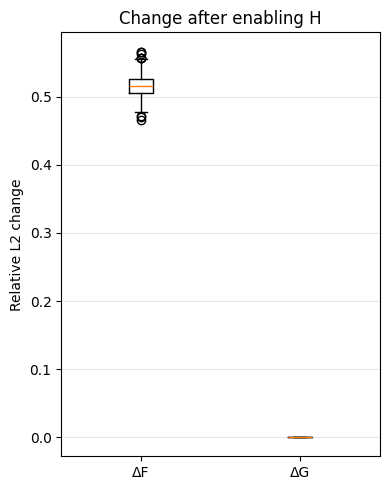

In [4]:
if __name__ == "__main__":
    MSE_FG, MSE_FGH, common_files_feat = run_A1()
    delta_F, delta_G, common_files_ckpt = run_A2()

In [5]:
def compute_G_location_consistency(field_dir: str,
                                   file_list: list[str],
                                   max_images: int | None = None) -> np.ndarray:

    if max_images is not None:
        file_list = file_list[:max_images]

    first_ckpt = torch.load(os.path.join(field_dir, file_list[0]), map_location="cpu")
    G0 = first_ckpt["G_shared_artifacts"] # (1, C, H, W)
    _, C, H, W = G0.shape

    sum_vecs = np.zeros((H, W, C), dtype=np.float64)
    count = 0

    for fname in file_list:
        ckpt = torch.load(os.path.join(field_dir, fname), map_location="cpu")
        G = ckpt["G_shared_artifacts"]           # (1, C, H, W)
        G = G[0]                                 # (C, H, W)
        G = G.permute(1, 2, 0).contiguous()      # (H, W, C)
        G_np = G.numpy().astype(np.float32)

        norm = np.linalg.norm(G_np, axis=-1, keepdims=True) + 1e-8
        G_unit = G_np / norm    # (H, W, C)

        sum_vecs += G_unit
        count += 1

    mean_vecs = sum_vecs / max(count, 1)
    loc_score = np.linalg.norm(mean_vecs, axis=-1)    # (H, W)
    return loc_score.astype(np.float32)


def run_B1_G(max_images: int | None = 200, compare_FG_only: bool = True):
    """
    B1-G: compute the location consistency of G -> heatmap of size (H, W)
    """
    files_FGH = sorted(os.listdir(dir_FGH_field_final))
    print(f"[B1-G] FGH ckpts: {len(files_FGH)}, using up to {max_images}")

    loc_G_FGH = compute_G_location_consistency(dir_FGH_field_final, files_FGH, max_images)
    print("[B1-G] FGH G location consistency done.")

    if compare_FG_only:
        files_FG = sorted(os.listdir(dir_FG_field))
        print(f"[B1-G] FG-only ckpts: {len(files_FG)}, using up to {max_images}")
        loc_G_FG = compute_G_location_consistency(dir_FG_field, files_FG, max_images)
        print("[B1-G] FG-only G location consistency done.")
    else:
        loc_G_FG = None

    if compare_FG_only and loc_G_FG is not None:
        vmin = min(loc_G_FGH.min(), loc_G_FG.min())
        vmax = max(loc_G_FGH.max(), loc_G_FG.max())

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(loc_G_FGH, vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("G Location Consistency (FGH)")

        plt.subplot(1, 2, 2)
        plt.imshow(loc_G_FG, vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("G Location Consistency (FG-only)")

        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(4, 4))
        plt.imshow(loc_G_FGH)
        plt.colorbar()
        plt.title("G Location Consistency (FGH)")
        plt.tight_layout()
        plt.show()

    print(f"[B1-G] FGH loc_G mean={loc_G_FGH.mean():.4f}, std={loc_G_FGH.std():.4f}")
    if loc_G_FG is not None:
        print(f"[B1-G] FG-only loc_G mean={loc_G_FG.mean():.4f}, std={loc_G_FG.std():.4f}")

    return loc_G_FGH, loc_G_FG


In [6]:
def cosine_sim(a: np.ndarray, b: np.ndarray):
    a = a.astype(np.float32)
    b = b.astype(np.float32)
    num = float((a * b).sum())
    denom = float(np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)
    return num / denom


def run_B2_G(field_dir: str,
             max_images: int = 100,
             num_samples: int = 20000):
    """
    Another angle of part B. Use cosine similarity.
    """
    
    files = sorted(os.listdir(field_dir))
    n_img = min(max_images, len(files))
    selected_files = files[:n_img]
    print(f"[B2-G] Using {n_img} trained fields")

    G_list = []
    for fname in selected_files:
        ckpt = torch.load(os.path.join(field_dir, fname), map_location="cpu")
        G = ckpt["G_shared_artifacts"]       # (1, C, H, W)
        G = G[0]                             # (C, H, W)
        G = G.permute(1, 2, 0).contiguous()  # (H, W, C)
        G_list.append(G.numpy().astype(np.float32))

    G_arr = np.stack(G_list, axis=0)  # (N, H, W, C)
    N, H, W, C = G_arr.shape
    print(f"[B2-G] G array shape: N={N}, H={H}, W={W}, C={C}")

    same_loc = []
    diff_loc = []

    rng = np.random.default_rng(seed=42)

    for _ in range(num_samples):
        # same (h,w), different images
        h = rng.integers(0, H)
        w = rng.integers(0, W)
        k1, k2 = rng.choice(N, size=2, replace=False)
        v1 = G_arr[k1, h, w, :]
        v2 = G_arr[k2, h, w, :]
        same_loc.append(cosine_sim(v1, v2))

        # same image, different (h,w)
        k = rng.integers(0, N)
        h1 = rng.integers(0, H)
        w1 = rng.integers(0, W)
        h2 = rng.integers(0, H)
        w2 = rng.integers(0, W)
        while (h1 == h2) and (w1 == w2):
            h2 = rng.integers(0, H)
            w2 = rng.integers(0, W)
        v1 = G_arr[k, h1, w1, :]
        v2 = G_arr[k, h2, w2, :]
        diff_loc.append(cosine_sim(v1, v2))

    same_loc = np.array(same_loc)
    diff_loc = np.array(diff_loc)

    print(f"[B2-G] same-loc mean cosine: {same_loc.mean():.4f}")
    print(f"[B2-G] diff-loc mean cosine: {diff_loc.mean():.4f}")

    plt.figure(figsize=(6, 4))
    plt.hist(same_loc, bins=50, alpha=0.7, label="same (h,w), diff images")
    plt.hist(diff_loc, bins=50, alpha=0.7, label="same image, diff (h,w)")
    plt.legend()
    plt.xlabel("cosine similarity")
    plt.ylabel("count")
    plt.title(f"G cosine distribution")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

    return same_loc, diff_loc


[B1-G] FGH ckpts: 954, using up to 200
[B1-G] FGH G location consistency done.
[B1-G] FG-only ckpts: 963, using up to 200
[B1-G] FG-only G location consistency done.


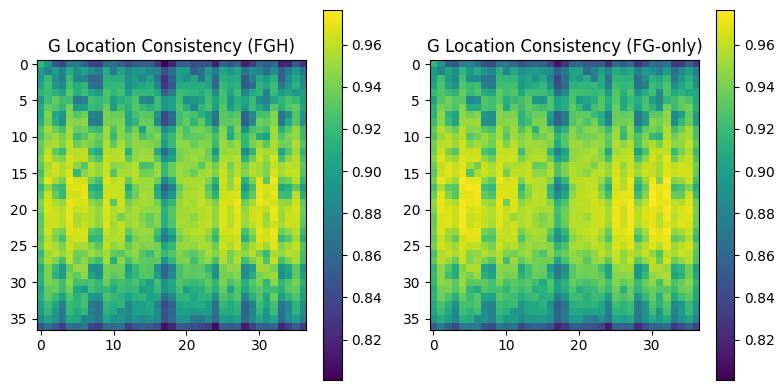

[B1-G] FGH loc_G mean=0.9217, std=0.0333
[B1-G] FG-only loc_G mean=0.9285, std=0.0320
[B2-G] Using 100 trained fields
[B2-G] G array shape: N=100, H=37, W=37, C=768
[B2-G] same-loc mean cosine: 0.8511
[B2-G] diff-loc mean cosine: 0.0053


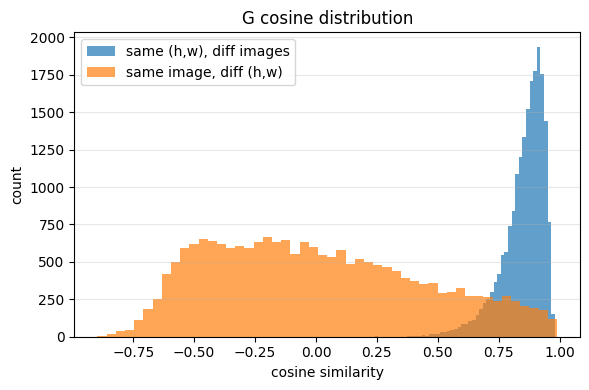

In [7]:
if __name__ == "__main__":
    loc_G_FGH, loc_G_FG = run_B1_G(max_images=200, compare_FG_only=True)

    same_loc_FGH, diff_loc_FGH = run_B2_G(dir_FGH_field_final,
                                          max_images=100,
                                          num_samples=20000)
